In [1]:
# matplotlib inline plotting
%matplotlib inline
# make inline plotting higher resolution
%config InlineBackend.figure_format = 'svg'

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.stats import t
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

# local imports
from events import political
from helpers.pretty_print import pval_descriptives, pretty_print_pval
from helpers.sql import connect_to_db, update_database, read_db

from helpers.ar_model import transformation

plt.style.use('ggplot')

In [3]:
# static

# number of obs in a year
YEARLY_BUSINESS_DAYS: int = 250

SIGNIFICANT_DIGITS = 5
START_DATE = '2009-10-13' # first date we have full politics UCP
#START_DATE = "2009-03-02" # the old start date - should not be used (!)

TOPICS = [
    "aggregate_transformed_residuals",
    "weather_extremes_transformed_residuals",
    "importance_of_human_intervantion_transformed_residuals",
    "politics_transformed_residuals",
]

names = {
    "0.1": "Deciles",
    "0.2": "Quintiles",
    "aggregate_transformed_residuals": "Aggregate",
    "politics_transformed_residuals": "Politics",
    "weather_extremes_transformed_residuals": "Weather Extremes",
    "importance_of_human_intervantion_transformed_residuals": "Imp. of Human Intervention",
    "vix": "VIX",
    "risk_aversion": "Risk Aversion",
    
    "CAPM": "CAPM",
    "FF3_C": "FFC",
    "FF3": "FF3",
    "FF5": "FF5",

    "bottom": "Bottom",
    "top": "Top",
}


In [4]:
# Connect to database (downloads if not exist)
engine = connect_to_db()

# Set this to True to update database locally
update = False

if update:
    update_database()

In [5]:
# Loading data
sentiment_sum_ar1 = read_db(
    engine=engine, statement="select * from climate_sum_ar1", idx_col="date"
)

sentiment_mean_n_ar1 = read_db(
    engine=engine, statement="select * from climate_mean_n_ar1", idx_col="date"
)

factors = read_db(
    engine=engine, statement="select * from factors", idx_col="date"
)

uncertainty = read_db(
    engine=engine, statement="select * from uncertainty", idx_col="date"
)

### Creating plot with 30-days MA sum sentiment

In [6]:
# Creating 30-days moving average of aggregate sentiment
sentiment = pd.DataFrame()
sentiment["ma30_sum"] = (
    sentiment_sum_ar1["aggregate_transformed_residuals"].rolling(30).mean().dropna()
)
sentiment["ma30_mean_n"] = (
    sentiment_mean_n_ar1["aggregate_transformed_residuals"].rolling(30).mean().dropna()
)

sentiment.head()


,ma30_sum,ma30_mean_n
2009-03-31,-0.461777,-0.028316
2009-04-01,-0.459003,-0.028967
2009-04-02,-0.495546,-0.037058
2009-04-03,-0.593098,-0.040608
2009-04-04,-0.543190,-0.037206


In [7]:
# Added for the archive... and in case we need it later
def plot_with_events(
    dataframe,
    column,
    title,
    ylabel,
    series_label,
    save=False,
    filename="test.png",
    figsize=(12, 10),
):
    fig, ax = plt.subplots(figsize=figsize)

    dataframe[column].plot(
        ax=ax,
        color="tab:gray",
        title=title,
        xlabel="Time",
        ylabel=ylabel,
        label=series_label,
    )
    for key, value in political.items():
        ax.plot(
            pd.Timestamp(value["date"]),
            dataframe.loc[value["date"]][column],
            marker="o",
            markersize="12",
            label=value["event"],
        )

    # Add legend
    plt.legend()

    if save:
        fig.savefig(f"plots/{filename}", dpi=300)

    return (fig, ax)


# plot_with_events(
#     dataframe=sentiment,
#     column="ma30_aggregate_transformed_residuals",
#     title=r"Aggregate sentiment v1 (30-day moving average)",
#     ylabel="Innovations in sentiment",
#     series_label="30-day moving average",
#     save = True, filename="aggregate_sentiment_sum.png"
# )

# plt.show()


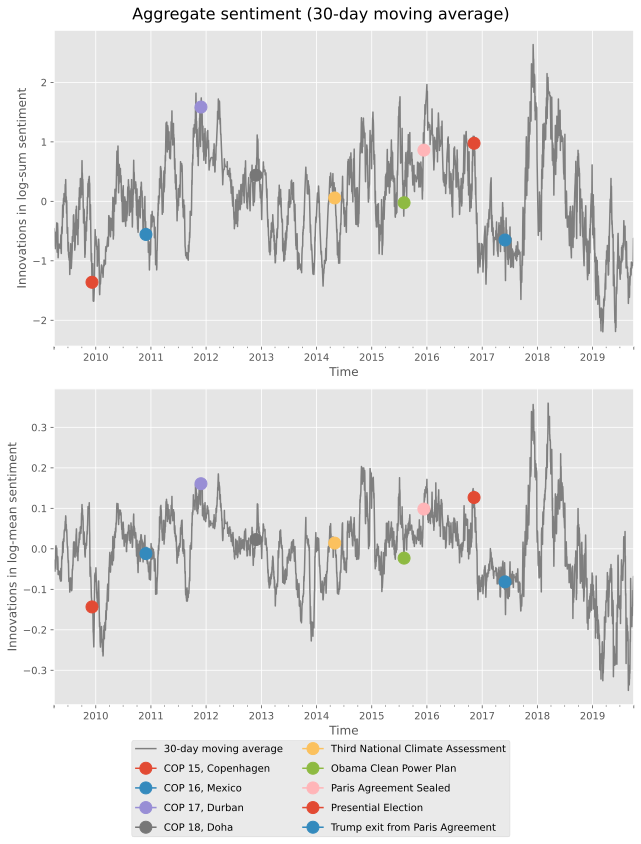

In [8]:
def plot_with_events_multiple(
    dataframe,
    columns,
    ylabels,
    title,
    series_label,
    save=False,
    filename="test.png",
    figsize=(14, 6),
    stacked=True,
):
    if stacked:
        # Create figure and axes
        fig, (ax1, ax2) = plt.subplots(
            2, 1, figsize=(figsize[1] * 1.5, figsize[0] * 0.75)
        )
        legend_cols = 2
        padding = -0.125
    if not stacked:
        # Create figure and axes
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        legend_cols = 5
        padding = -0.1

    axes = [ax1, ax2]

    for i, column in enumerate(columns):
        dataframe[column].plot(
            ax=axes[i],
            color="tab:gray",
            # title=title,
            xlabel="Time",
            ylabel=ylabels[i],
            label=series_label,
        )

    for i, ax in enumerate(axes):
        for key, value in political.items():
            ax.plot(
                pd.Timestamp(value["date"]),
                dataframe.loc[value["date"]][columns[i]],
                marker="o",
                markersize="12",
                label=value["event"],
            )

    # Add title
    fig.suptitle(title, fontsize=16)

    # add legend
    plt.figlegend(
        loc="lower center",
        ncol=legend_cols,
        labelspacing=1,
        bbox_to_anchor=(0.5, padding),
        handles=axes[0].get_legend_handles_labels()[0],
    )

    # adjust spacing
    plt.tight_layout()

    if save:
        fig.savefig(f"plots/{filename}", dpi=300, bbox_inches="tight")

    return (fig, axes)


plot_with_events_multiple(
    dataframe=sentiment,
    columns=["ma30_sum", "ma30_mean_n"],
    title=r"Aggregate sentiment (30-day moving average)",
    ylabels=["Innovations in log-sum sentiment", "Innovations in log-mean sentiment"],
    series_label="30-day moving average",
    save=True,
    filename="aggregate_sentiment_sum.png",
    stacked=True,
)

plt.show()


### Correlation matrix with extra information
The following produced table needs to be in Twitter data section. Especially to highlight how the different climate factors interact --> Low correlation could indicate that carry different sorts of climate information.

In [9]:
def generate_df_descriptives(fac, sent):
    # This is the code that we used to create the correlation matrix for the sum variation of sentiment

    # Getting relevant factors
    factors_rel = fac[["mkt-rf", "smb", "hml", "mom", "rmw", "cma"]] * YEARLY_BUSINESS_DAYS

    climate_rel = sent[TOPICS]

    # Merging
    factors_rel = factors_rel.merge(climate_rel, left_index=True, right_index=True)
    factors_rel = factors_rel.dropna()

    # get n - also used as degrees of freedom in pvalues
    n = factors_rel.shape[0]
    print(n)

    # Renaming colunms names so that we are only dealing with lower case letters
    factors_rel.columns = factors_rel.columns.map(
        lambda x: x.lower().replace("_transformed_residuals", "")
    )

    # Correlations
    correlations = factors_rel.corr()

    # Mean, standard error and t-statistics for factors
    df_descriptives = pd.DataFrame()

    print(factors_rel.index.min(), factors_rel.index.max())
    display(factors_rel)

    df_descriptives["mean"] = factors_rel.mean()
    df_descriptives["Mean std. error"] = factors_rel.std() / np.sqrt(n)
    df_descriptives["t_stat"] = factors_rel.mean() / df_descriptives["Mean std. error"]

    # Merging
    #df_descriptives = df_descriptives.merge(
    #    correlations, left_index=True, right_index=True
    #)

    tstat_as_strings = []

    for idx, row in df_descriptives.iterrows():
        # TODO: change degrees of freedom to correct value
        #sig = pval_descriptives(row['t_stat'], n)

        #if sig:
        #    means_as_strings.append(pretty_print_pval(sig, row['mean'], SIGNIFICANT_DIGITS))

        tstat_as_strings.append(pretty_print_pval(row['t_stat'], n, SIGNIFICANT_DIGITS))

    df_descriptives['t_stat'] = tstat_as_strings

    return df_descriptives


df_descriptives = generate_df_descriptives(factors, sentiment_sum_ar1)

df_descriptives


2510
2009-10-12 00:00:00 2019-10-01 00:00:00


,mkt-rf,smb,hml,mom,rmw,cma,aggregate,weather_extremes,importance_of_human_intervantion,politics
2009-10-12,0.900,-1.200,0.800,-0.550,0.125,0.575,-3.277686,-1.274750,-2.185545,-2.192649
2009-10-13,-0.550,0.125,-0.400,0.425,-0.050,-0.025,2.782895,-0.833761,3.010081,3.341731
2009-10-14,4.325,0.425,2.925,0.550,-1.525,0.650,-2.036134,-0.694314,1.752310,-2.655519
2009-10-15,0.875,-0.725,-1.150,0.175,2.025,-0.675,6.515842,-1.291962,1.802475,2.492514
2009-10-16,-2.050,-0.400,-3.125,-0.225,1.900,-0.950,-2.521948,-0.512849,-3.922507,1.251181
...,...,...,...,...,...,...,...,...,...,...
2019-09-25,1.725,1.050,1.300,-1.600,1.050,0.025,-0.998176,-4.355560,-3.448189,0.898549
2019-09-26,-1.025,-2.450,0.300,2.025,0.875,0.725,-1.093080,-0.036139,1.159468,-0.976933
2019-09-27,-1.550,-0.425,2.200,-1.775,0.600,1.400,-1.335222,-0.568595,1.396431,1.080115
2019-09-30,1.250,-0.650,-1.200,0.500,1.550,-0.050,-6.715307,-1.554332,-3.276438,-1.302721


,mean,Mean std. error,t_stat
mkt-rf,0.127490,0.048268,(2.64130) (***)
smb,-0.007410,0.026115,(-0.28376)
hml,-0.027042,0.025439,(-1.06299)
mom,0.049492,0.034434,(1.43731) (*)
rmw,0.018655,0.017414,(1.07130)
cma,0.002241,0.014673,(0.15273)
aggregate,-0.032753,0.065536,(-0.49977)
weather_extremes,-0.228985,0.044832,(-5.10761) (***)
importance_of_human_intervantion,0.068408,0.044254,(1.54581) (*)
politics,-0.114987,0.042609,(-2.69867) (***)


In [10]:
def print_latex_table(df, decimals=None):
    latex = df.to_latex(
        index=True,
        escape=True,
        sparsify=True,
        multirow=True,
        multicolumn=True,
        bold_rows=True,
        na_rep="",
        multicolumn_format="c",
        float_format=f"{{:.{SIGNIFICANT_DIGITS}f}}".format if decimals is None else f"{{:.{decimals}f}}".format,
        position="H",
    )

    latex = re.sub(r"\\(mid|top|bottom)rule", "", latex)
    print(latex)

    return


#df_descriptives.to_latex()

print_latex_table(df_descriptives)

\begin{table}[H]
\centering
\begin{tabular}{lrrl}

{} &     mean &  Mean std. error &            t\_stat \\

\textbf{mkt-rf                          } &  0.12749 &          0.04827 &   (2.64130) (***) \\
\textbf{smb                             } & -0.00741 &          0.02611 &        (-0.28376) \\
\textbf{hml                             } & -0.02704 &          0.02544 &        (-1.06299) \\
\textbf{mom                             } &  0.04949 &          0.03443 &     (1.43731) (*) \\
\textbf{rmw                             } &  0.01866 &          0.01741 &         (1.07130) \\
\textbf{cma                             } &  0.00224 &          0.01467 &         (0.15273) \\
\textbf{aggregate                       } & -0.03275 &          0.06554 &        (-0.49977) \\
\textbf{weather\_extremes                } & -0.22898 &          0.04483 &  (-5.10761) (***) \\
\textbf{importance\_of\_human\_intervantion} &  0.06841 &          0.04425 &     (1.54581) (*) \\
\textbf{politics                

/var/folders/3b/lkjl6nz51lb5h1pjxb6ljm6r0000gn/T/ipykernel_8521/2665971584.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df.to_latex(


# Correlations for factors and uncertainty indices

In [11]:
TOPICS

['aggregate_transformed_residuals',
 'weather_extremes_transformed_residuals',
 'importance_of_human_intervantion_transformed_residuals',
 'politics_transformed_residuals']

In [12]:
corr = factors[["mkt-rf", "smb", "hml", "mom", "rmw", "cma"]]
corr = pd.merge(left=corr, right=sentiment_sum_ar1[TOPICS], left_index=True, right_index=True)
corr = pd.merge(left=corr, right=uncertainty, left_index=True, right_index=True)

# set names
corr.columns = corr.columns.map(lambda x: names.get(x) if names.get(x) else x)

corr = corr.dropna()

print(corr.index.min(), corr.index.max())

corr = corr.corr()

corr

2009-10-13 00:00:00 2019-10-01 00:00:00


,mkt-rf,smb,hml,mom,rmw,cma,Aggregate,Weather Extremes,Imp. of Human Intervention,Politics,VIX,Risk Aversion
mkt-rf,1.000000,0.346005,0.144604,0.022186,-0.448032,-0.101385,-0.002647,0.020915,-0.024493,-0.003644,-0.180474,-0.208014
smb,0.346005,1.000000,0.073136,-0.084033,-0.357642,0.015575,-0.006280,0.001743,-0.030064,0.003602,-0.042282,-0.055617
hml,0.144604,0.073136,1.000000,-0.330421,-0.220605,0.561758,-0.001911,0.029782,-0.021960,-0.016913,-0.048233,-0.055800
mom,0.022186,-0.084033,-0.330421,1.000000,0.018331,-0.128421,-0.005361,0.005652,0.007230,0.014502,-0.006311,-0.013792
rmw,-0.448032,-0.357642,-0.220605,0.018331,1.000000,-0.029230,0.019465,0.008680,0.019619,-0.003878,0.092918,0.108749
cma,-0.101385,0.015575,0.561758,-0.128421,-0.029230,1.000000,-0.008364,0.008189,-0.017191,-0.019283,0.039538,0.029093
Aggregate,-0.002647,-0.006280,-0.001911,-0.005361,0.019465,-0.008364,1.000000,0.315937,0.393829,0.198547,0.012078,0.017120
Weather Extremes,0.020915,0.001743,0.029782,0.005652,0.008680,0.008189,0.315937,1.000000,0.007823,0.078922,0.025243,0.022533
Imp. of Human Intervention,-0.024493,-0.030064,-0.021960,0.007230,0.019619,-0.017191,0.393829,0.007823,1.000000,0.011399,-0.016809,-0.015328
Politics,-0.003644,0.003602,-0.016913,0.014502,-0.003878,-0.019283,0.198547,0.078922,0.011399,1.000000,-0.013325,0.002734


In [13]:
# remove above diagonal
corr = pd.DataFrame(np.tril(corr.values), columns=corr.columns, index=corr.index).replace(0, np.nan)

print_latex_table(corr, decimals=3)

\begin{table}[H]
\centering
\begin{tabular}{lrrrrrrrrrrrr}

{} &  mkt-rf &    smb &    hml &    mom &    rmw &    cma &  Aggregate &  Weather Extremes &  Imp. of Human Intervention &  Politics &   VIX &  Risk Aversion \\

\textbf{mkt-rf                    } &   1.000 &        &        &        &        &        &            &                   &                             &           &       &                \\
\textbf{smb                       } &   0.346 &  1.000 &        &        &        &        &            &                   &                             &           &       &                \\
\textbf{hml                       } &   0.145 &  0.073 &  1.000 &        &        &        &            &                   &                             &           &       &                \\
\textbf{mom                       } &   0.022 & -0.084 & -0.330 &  1.000 &        &        &            &                   &                             &           &       &                \\
\t

/var/folders/3b/lkjl6nz51lb5h1pjxb6ljm6r0000gn/T/ipykernel_8521/2665971584.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df.to_latex(


### Creating table for counting within each topic
Constructing table with the purpose of showing count of tweets within different topics for specific years.

In [14]:
# This code constructs table with counts of tweet for each topic for each year
df_count = (
    sentiment_sum_ar1.filter(regex="(aggregate|weather.+|importance.+|politics)_count")
    .resample("Y")
    .sum()
)

# Converting index to year only
df_count.index = df_count.index.map(lambda x: x.year)

# needs float type to pretty-print latex
df_count = df_count.astype(float)

df_count


,aggregate_count,weather_extremes_count,importance_of_human_intervantion_count,politics_count
2006,12.0,7.0,1.0,0.0
2007,3961.0,1096.0,1074.0,189.0
2008,29980.0,9275.0,4807.0,2276.0
2009,489069.0,103381.0,104609.0,43812.0
2010,447887.0,162825.0,34885.0,27945.0
2011,317864.0,154169.0,7559.0,7320.0
2012,198691.0,104852.0,4825.0,4176.0
2013,282476.0,137009.0,7599.0,6416.0
2014,408451.0,173133.0,24159.0,14843.0
2015,1259359.0,161175.0,239367.0,148113.0


In [15]:
latex = df_count.to_latex(
    index=True,
    escape=True,
    sparsify=True,
    multirow=True,
    multicolumn=True,
    bold_rows=False,
    na_rep="",
    multicolumn_format="c",
    float_format="{:,.0f}".format,
    position="H",
)

latex = re.sub(r"\\(mid|top|bottom)rule", "", latex)
print(latex)


\begin{table}[H]
\centering
\begin{tabular}{lrrrr}

{} &  aggregate\_count &  weather\_extremes\_count &  importance\_of\_human\_intervantion\_count &  politics\_count \\

2006 &               12 &                       7 &                                       1 &               0 \\
2007 &            3,961 &                   1,096 &                                   1,074 &             189 \\
2008 &           29,980 &                   9,275 &                                   4,807 &           2,276 \\
2009 &          489,069 &                 103,381 &                                 104,609 &          43,812 \\
2010 &          447,887 &                 162,825 &                                  34,885 &          27,945 \\
2011 &          317,864 &                 154,169 &                                   7,559 &           7,320 \\
2012 &          198,691 &                 104,852 &                                   4,825 &           4,176 \\
2013 &          282,476 &            

/var/folders/3b/lkjl6nz51lb5h1pjxb6ljm6r0000gn/T/ipykernel_8521/4207739809.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_count.to_latex(


In [16]:
# # here I'm just testing to ensure, the count is correct with data stored in the database...


# # Loading in Twitter data
# df = read_db(engine=engine, statement="select * from twitter_kaggle")

# # Setting datetime (potentially, we should deal with time-zones problems)
# df["datetime"] = pd.to_datetime(df["created_at"])
# df = df.set_index(df["datetime"], drop=True)  # Setting index
# df.index.name = None

# df = df.drop(columns=["created_at", "datetime"])  # dropping irrelevant colunms


# df.loc[df.index < "2007-01-01"]


In [17]:
def ts_descriptives(df, model_name="log-sum"):
    results = {}

    # regex filter dataframe on columns
    df = df.filter(
        regex="(aggregate|weather.+|importance.+|politics)_transformed_residuals"
    ).copy()

    # supress statsmodels warnings
    df.index.freq = "D"

    for col in df.columns:
        fit = AutoReg(df[col].dropna(), lags=1).fit()

        results[col] = {
            "AR": fit.params[1],
            "AR_t": fit.tvalues[1],
            "mean": df[col].mean(),
            "std": df[col].std(),
            "model": model_name,
        }

    return results


desc = pd.DataFrame()


desc = pd.concat([desc, pd.DataFrame(ts_descriptives(sentiment_sum_ar1))], axis=1)
desc = pd.concat(
    [desc, pd.DataFrame(ts_descriptives(sentiment_mean_n_ar1, model_name="log-mean"))],
    axis=1,
)

desc = desc.T
desc["sent"] = desc.index
desc = desc.reset_index(drop=True)
desc["sent"] = desc["sent"].map(names)

# set multiindex
desc.set_index(['model', 'sent'], inplace=True)

In [18]:
desc

AR      AR_t      mean       std
model    sent                                                              
log-sum  Aggregate                   0.023704  1.474075  0.008665  3.270109
         Weather Extremes            0.019831  1.233083 -0.087858  2.232569
         Imp. of Human Intervention  0.020806  1.264601  0.039556  2.147936
         Politics                    0.026013  1.570418 -0.092177   2.05322
log-mean Aggregate                   0.063763   3.96606 -0.003376  0.402615
         Weather Extremes            0.068672  4.279167 -0.022158  0.426555
         Imp. of Human Intervention  0.025984   1.57925  0.011289  0.481689
         Politics                    0.076097  4.605819 -0.026192  0.504311

In [19]:
def print_latex_table(df):
    latex = df.to_latex(
        index=True,
        escape=True,
        sparsify=True,
        multirow=True,
        multicolumn=True,
        bold_rows=True,
        na_rep="",
        multicolumn_format="c",
        float_format=f"{{:.{SIGNIFICANT_DIGITS}f}}".format,
        position="H",
    )

    latex = re.sub(r"\\(mid|top|bottom)rule", "", latex)
    print(latex)

    return


#df_descriptives.to_latex()

print_latex_table(desc)

\begin{table}[H]
\centering
\begin{tabular}{llllll}

         &          &      AR &    AR\_t &     mean &     std \\
\textbf{model} & \textbf{sent} &         &         &          &         \\

\multirow{4}{*}{\textbf{log-sum}} & \textbf{Aggregate} & 0.02370 & 1.47408 &  0.00867 & 3.27011 \\
         & \textbf{Weather Extremes} & 0.01983 & 1.23308 & -0.08786 & 2.23257 \\
         & \textbf{Imp. of Human Intervention} & 0.02081 & 1.26460 &  0.03956 & 2.14794 \\
         & \textbf{Politics} & 0.02601 & 1.57042 & -0.09218 & 2.05322 \\
\cline{1-6}
\multirow{4}{*}{\textbf{log-mean}} & \textbf{Aggregate} & 0.06376 & 3.96606 & -0.00338 & 0.40261 \\
         & \textbf{Weather Extremes} & 0.06867 & 4.27917 & -0.02216 & 0.42655 \\
         & \textbf{Imp. of Human Intervention} & 0.02598 & 1.57925 &  0.01129 & 0.48169 \\
         & \textbf{Politics} & 0.07610 & 4.60582 & -0.02619 & 0.50431 \\

\end{tabular}
\end{table}



/var/folders/3b/lkjl6nz51lb5h1pjxb6ljm6r0000gn/T/ipykernel_8521/4289159342.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df.to_latex(


# Plot (concave) mapping function

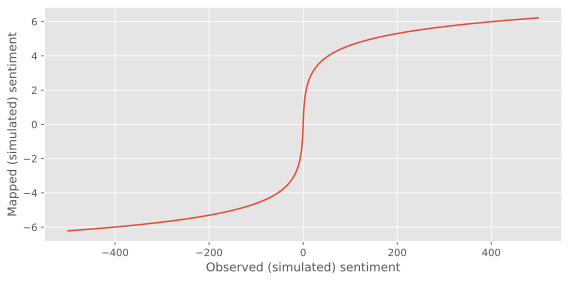

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

X = np.linspace(-500, 500, int(10e6))
Y = transformation(X, type_of="log")

ax.plot(X, Y)

ax.set_xlabel("Observed (simulated) sentiment")
ax.set_ylabel("Mapped (simulated) sentiment")

# ax.set_title("Simulated sentiment transformation")

plt.tight_layout()

fig.savefig(f"plots/simulated_sentiment.png", dpi=450, bbox_inches="tight")

plt.show()


In [21]:
sentiment_sum_ar1.filter(regex='.+_transformed_residuals$')

,aggregate_transformed_residuals,weather_extremes_transformed_residuals,importance_of_human_intervantion_transformed_residuals,seriousness_of_gas_emissions_transformed_residuals,ideological_positions_on_global_warming_transformed_residuals,impact_of_resource_overconsumption_transformed_residuals,global_stance_transformed_residuals,politics_transformed_residuals,significance_of_pollution_awareness_events_transformed_residuals,donald_trump_versus_science_transformed_residuals,undefined_one_word_hashtags_transformed_residuals
2006-06-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2019-09-27,-1.335222,-0.568595,1.396431,-0.963912,-0.333878,-1.075566,1.313887,1.080115,0.342165,-0.968083,-0.066903
2019-09-28,6.307765,0.334885,1.750825,-1.083411,0.151391,-0.268492,1.313457,3.569064,0.392302,0.402596,-0.592287
2019-09-29,3.145557,2.195954,1.678814,2.815884,0.207572,1.198240,1.589900,-1.221098,-1.128252,0.781450,-0.914545
2019-09-30,-6.715307,-1.554332,-3.276438,1.986908,0.610711,-0.044017,-8.168032,-1.302721,1.207050,2.832967,-0.267953
